<a href="https://colab.research.google.com/github/BoyarinO/DistilBERT/blob/main/DistilBERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>0) Setup env</h3>

In [1]:
! pip install datasets transformers[torch] seqeval scikit-learn optimum[exporters]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.1 

In [2]:
import re
import os
import json
from datasets import load_dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, DistilBertForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
from optimum.onnxruntime import ORTModelForTokenClassification
import seqeval
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from seqeval.metrics import precision_score, recall_score
from typing import *

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from huggingface_hub import notebook_login
notebook_login()

<h3>1) Init vars</h3>

In [39]:
dbert_model_name = 'distilbert/distilbert-base-uncased'
top_label_count = 4
total_rows = 100000

model_save_dir_path = '/content/gdrive/My Drive/model/'
model_save_name = f"{dbert_model_name.split('/')[-1]}_ner_finetuned"

dataset_file_name = f'finer-139_top_rows_{total_rows}_top_labels_{top_label_count}'
labels_file_name = f'labels_finer-139_top_rows_{total_rows}_top_labels_{top_label_count}'

<h3> DistilBert Trainer class wrapper</h3>

In [106]:
class DistilBertTrainer:
    """
    A class designed for fine-tuning the DistilBert model on the FiNER dataset for named entity recognition (NER) tasks.
    It includes methods for dataset loading, preprocessing, model training, evaluation, and saving model artifacts.
    The class provides functionalities to handle specific dataset characteristics, such as selecting the top labels,
    tokenizing and aligning labels with tokens, and calculating evaluation metrics along with their confidence intervals.

    Methods:
    - load_data: Loads a subset of the FiNER dataset.
    - select_top_labels: Selects the most frequent labels from the dataset.
    - split_dataset: Splits the dataset into training, testing, and validation sets.
    - load_model_data: Loads the tokenizer and DistilBert model.
    - _tokenize_and_align_labels: Tokenizes the texts and aligns the labels with the tokens.
    - process_data: Processes the dataset to prepare it for training.
    - train: Trains the DistilBert model on the processed dataset.
    - save_data_to_local: Saves the model, dataset, and labels to the local file system.
    - _plot_conf_matrix: Plots the confusion matrix for model evaluation.
    - eval_model: Evaluates the model's performance and prints/plots the results.
    - _compute_metrics_ci: Computes confidence intervals for the precision and recall metrics.

    Utility Functions:
    - bootstrap_confidence_interval: Calculates confidence intervals for a given metric using bootstrap resampling.

    """
    @classmethod
    def load_data(cls, dataset_url: str = "nlpaueb/finer-139", n_records: int = 1000) -> Dataset:
        """
        Loads a specified number of records from a given dataset URL.

        Parameters:
        - dataset_url (str): The URL of the dataset to load. Defaults to "nlpaueb/finer-139".
        - n_records (int): The number of records to load from the dataset. Defaults to 1000.

        Returns:
        - Dataset: A `Dataset` object containing the loaded data.
        """
        dataset = load_dataset(dataset_url, split=f'train[0:{n_records}]')

        return dataset

    @classmethod
    def select_top_labels(cls, dataset, top_labels: int = 4) -> Tuple[List[str], List[int]]:
        """
        Selects the most frequent labels from the dataset, considering multi-token labels as a single feature.

        Parameters:
        - dataset: The dataset from which labels are to be selected.
        - top_labels (int): The number of top labels to select. Defaults to 4.

        Returns:
        - Tuple[List[str], List[int]]: A tuple containing two lists:
          1. selected_top_labels (List[str]): The names of the selected labels.
          2. selected_top_labels_index (List[int]): The index positions of the selected labels in the dataset.
        """

        selected_top_labels = []

        unique_labels, unique_counts = np.unique(np.concatenate(dataset['ner_tags']), return_counts=True)
        all_labels_names = dataset.features['ner_tags'].feature.names

        # get labels count by ascending
        unique_counts_sort = np.argsort(unique_counts)[::-1]

        found_labels = 0
        label_arr_index = 0

        # +1 due to 'O' class
        while found_labels < top_labels + 1:
            label_index = unique_counts_sort[label_arr_index]
            label_name = all_labels_names[label_index]

            label_arr_index += 1

            if label_name in selected_top_labels:
                continue

            # in case with class names: "B-AccrualForEnvironmentalLossContingencies", "I-AccrualForEnvironmentalLossContingencies"
            # we need to get root name "AccrualForEnvironmentalLossContingencies" and count this as 1 feature
            label_name_root = label_name.split('-')[-1]
            label_names = [l_name for l_name in all_labels_names if label_name_root == l_name.split('-')[-1]]
            selected_top_labels += label_names

            found_labels += 1

        selected_top_labels_index = dataset.features['ner_tags'].feature.str2int(selected_top_labels)

        return selected_top_labels, selected_top_labels_index

    @classmethod
    def split_dataset(cls, dataset, test_size: float = 0.3, valid_size: float = 0.5,
                      split_col: str = 'labels') -> DatasetDict:
        """
        Splits the dataset into training, testing, and validation sets.

        Parameters:
        - dataset: The dataset to be split.
        - test_size (float): The proportion of the dataset to include in the test split. Defaults to 0.3.
        - valid_size (float): The proportion of the test split to include in the validation set. Defaults to 0.5.
        - split_col (str): The column used for stratified splitting. Defaults to 'labels'.

        Returns:
        - DatasetDict: A dictionary containing the training, testing, and validation datasets.
        """

        # Add extra col to make stratified split
        stratify_column_name = 'split_col'
        dataset = dataset.map(
            lambda x: {stratify_column_name: str(set(filter(lambda y: y >= 0, x[split_col])))}).class_encode_column(
            stratify_column_name)

        train_testvalid = dataset.train_test_split(test_size=test_size, stratify_by_column=stratify_column_name)
        test_valid = train_testvalid['test'].train_test_split(test_size=valid_size)

        dataset = DatasetDict(
            {'train': train_testvalid['train'], 'test': test_valid['test'], 'validation': test_valid['train']})

        return dataset

    @classmethod
    def load_model_data(cls, num_labels: int, model_name: str) \
            -> Tuple[AutoTokenizer, DistilBertForTokenClassification]:
        """
        Loads the tokenizer and model for DistilBert fine-tuning.

        Parameters:
        - num_labels (int): The number of labels in the dataset.
        - model_name (str): The name of the DistilBert model to be loaded.

        Returns:
        - Tuple[AutoTokenizer, DistilBertForTokenClassification]: A tuple containing the tokenizer and model.
        """
        tokenizer = AutoTokenizer.from_pretrained(model_name)

        model = DistilBertForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

        return tokenizer, model

    @classmethod
    def _tokenize_and_align_labels(
            cls,
            examples,
            tokenizer,
            selected_labels_index,
            label_all_tokens: bool,
            max_length: int,
            padding: Union[str, bool],
            truncation: bool) -> Dict[str, Union[List[int], List[List[int]]]]:
        """
        Tokenizes the input examples and aligns the labels to the tokens.

        Parameters:
        - examples: The input examples to be tokenized.
        - tokenizer: The tokenizer to be used.
        - selected_labels_index: The indices of the labels selected for training.
        - label_all_tokens (bool): Whether to label all sub-tokens of a word. Defaults to True.
        - max_length (int): The maximum length of the tokenized sequences. Defaults to 512.
        - padding (Union[str, bool]): The strategy to apply padding. Defaults to 'max_length'.
        - truncation (bool): Whether to truncate sequences to a maximum length. Defaults to True.

        Returns:
        - Dict[str, Union[List[int], List[List[int]]]]: A dictionary containing the tokenized inputs and their corresponding labels.
        """

        tokenized_inputs = tokenizer(
            examples["tokens"],
            truncation=truncation,
            is_split_into_words=True,
            max_length=max_length,
            padding=padding
        )
        selected_label_map = {label: idx for idx, label in enumerate(selected_labels_index)}

        labels = []
        for i, label in enumerate(examples[f"ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            filtered_labels = [selected_label_map[l_index] if l_index in selected_labels_index else 0 for l_index in
                               label]
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                # Special tokens have a word id that is None.
                # -100 automatically ignored in the loss function.
                if word_idx is None:
                    label_ids.append(-100)
                # Set the label for the first token of each word.
                elif word_idx != previous_word_idx:
                    label_ids.append(filtered_labels[word_idx])
                # For the other tokens in a word, set the label to either the current label or -100, depending on
                # the label_all_tokens flag.
                else:
                    label_ids.append(filtered_labels[word_idx] if label_all_tokens else -100)
                previous_word_idx = word_idx

            labels.append(label_ids)

        tokenized_inputs["labels"] = labels
        return tokenized_inputs

    @classmethod
    def process_data(
            cls,
            dataset,
            tokenizer,
            selected_labels_index,
            label_all_tokens: bool = True,
            max_length: int = 512,
            padding: Union[str, bool] = 'max_length',
            truncation: bool = True) -> Dataset:
        """
        Processes the dataset by tokenizing and aligning labels according to the specified parameters.

        Parameters:
        - dataset: The dataset to be processed.
        - tokenizer: The tokenizer to be used for processing.
        - selected_labels_index: The indices of the labels selected for training.
        - label_all_tokens (bool): Indicates if all tokens should be labeled. Defaults to True.
        - max_length (int): Maximum sequence length after tokenization. Defaults to 512.
        - padding (Union[str, bool]): Padding strategy to be used. Defaults to 'max_length'.
        - truncation (bool): Indicates if sequences should be truncated. Defaults to True.

        Returns:
        - Dataset: The processed dataset with tokenized inputs and aligned labels.
        """

        tokenized_dataset = dataset.map(
            cls._tokenize_and_align_labels,
            batched=True,
            fn_kwargs={
                'tokenizer': tokenizer,
                'selected_labels_index': selected_labels_index,
                'label_all_tokens': label_all_tokens,
                'max_length': max_length,
                'padding': padding,
                'truncation': truncation
            }
        )

        return tokenized_dataset

    @classmethod
    def train(
            cls,
            model,
            model_checkpoint: str,
            tokenizer,
            tokenized_datasets,
            label_list,
            epochs: int = 5,
            batch_size: int = 16,
            max_seq_len: int = 512,
            learning_rate: float = 2e-5,
            weight_decay: float = 0.01
    ) -> Trainer:
        """
        Trains the model on the tokenized dataset with specified training parameters.

        Parameters:
        - model: The model to be trained.
        - model_checkpoint (str): The path or name of the model checkpoint.
        - tokenizer: The tokenizer used for the dataset.
        - tokenized_datasets: The dataset that has been tokenized and is ready for training.
        - label_list: The list of labels used in the dataset.
        - epochs (int): The number of training epochs. Defaults to 5.
        - batch_size (int): The batch size for training and evaluation. Defaults to 16.
        - max_seq_len (int): The maximum sequence length. Defaults to 512.
        - learning_rate (float): The learning rate for the AdamW optimizer. Defaults to 2e-5.
        - weight_decay (float): The weight decay for regularization. Defaults to 0.01.

        Returns:
        - Trainer: The Hugging Face Trainer instance configured for training.
        """

        model_name = model_checkpoint.split("/")[-1]

        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        num_update_steps_per_epoch = len(tokenized_datasets['train'])
        num_training_steps = epochs * num_update_steps_per_epoch

        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        args = TrainingArguments(
            f"{model_name}-finetuned-ner_finer_139",
            evaluation_strategy="epoch",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            push_to_hub=True
        )

        data_collator = DataCollatorForTokenClassification(tokenizer, padding=True, max_length=max_seq_len)

        metric = load_metric("seqeval")

        def compute_metrics(p):
            predictions, labels = p
            predictions = np.argmax(predictions, axis=2)

            # Remove ignored index (special tokens)
            true_predictions = [
                [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
            ]
            true_labels = [
                [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
            ]

            results = metric.compute(predictions=true_predictions, references=true_labels)
            return {
                "precision": results["overall_precision"],
                "recall": results["overall_recall"],
                "f1": results["overall_f1"],
                "accuracy": results["overall_accuracy"],
            }

        trainer = Trainer(
            model,
            args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
            optimizers=(optimizer, lr_scheduler),
            compute_metrics=compute_metrics
        )

        trainer.train()
        trainer.evaluate()

        return trainer

    @classmethod
    def save_data_to_local(
            cls,
            model,
            dataset,
            labels,
            model_dir: str,
            model_name: str,
            dataset_name: str,
            labels_name: str):
        """
        Saves the model, dataset, and labels to the local filesystem.

        Parameters:
        - model: The trained model to be saved.
        - dataset: The dataset used for training.
        - labels: The labels selected for training.
        - model_dir (str): The directory where the model and data will be saved.
        - model_name (str): The name to save the model under.
        - dataset_name (str): The name to save the dataset under.
        - labels_name (str): The name to save the labels under.
        """

        os.makedirs(model_dir, exist_ok=True)

        # Save the model
        model.save_model(f'{model_dir}/{model_name}')

        # Save the dataset
        dataset.save_to_disk(f'{model_dir}/{dataset_name}')

        # Save selected labels
        with open(f'{model_dir}/{labels_name}', 'wb') as f:
            np.save(f, top_selected_labels)

        # Save training log
        with open(f'{model_dir}/trainer_log_{model_name}.json', 'w') as fj:
            json.dump(model.state.log_history, fj)

    @classmethod
    def _plot_conf_matrix(cls, true_val_predictions, true_val_labels, top_selected_labels_loaded):
        """
        Plots the confusion matrix based on the true and predicted labels.

        Parameters:
        - true_val_predictions: The predictions made by the model.
        - true_val_labels: The true labels for the validation set.
        - top_selected_labels_loaded: The list of labels considered for the confusion matrix.
        """

        flat_true_val_predictions = np.concatenate(true_val_predictions)
        flat_true_val_labels = np.concatenate(true_val_labels)

        conf_matrix = confusion_matrix(flat_true_val_predictions, flat_true_val_labels, labels=top_selected_labels_loaded)

        pattern = '[^A-Z0-9-]'

        top_selected_labels_loaded_short = [re.sub(pattern, '', label_name) for label_name in top_selected_labels_loaded]

        plt.figure(figsize=(20, 12))
        ax = plt.subplot()
        sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)

        # labels, title and ticks
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(top_selected_labels_loaded_short)
        ax.yaxis.set_ticklabels(top_selected_labels_loaded_short)

    @classmethod
    def eval_model(cls, predictions, labels, label_list, verbose: bool = True) -> Tuple[Dict, Dict]:
        """
        Evaluates the model's performance on a dataset.

        Parameters:
        - predictions: The model's predictions.
        - labels: The true labels.
        - label_list: The list of labels used in the dataset.
        - verbose (bool): If True, prints detailed evaluation results. Defaults to True.

        Returns:
        - Tuple[Dict, Dict]: A tuple containing the evaluation results and confidence intervals for precision and recall metrics.
        """

        # Remove ignored index (special tokens)
        true_predictions = [
            [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        metric = load_metric("seqeval")
        eval_results = metric.compute(predictions=true_predictions, references=true_labels)

        ci_metrics_results = cls._compute_metrics_ci(predictions, labels, label_list)

        if verbose:
            print(eval_results)
            print(ci_metrics_results)
            cls._plot_conf_matrix(true_predictions, true_labels, label_list)

        return eval_results, ci_metrics_results

    @classmethod
    def _compute_metrics_ci(cls, predictions, labels, label_names) -> Dict[str, Tuple[float, float]]:
        """
        Computes confidence intervals for evaluation metrics using bootstrap resampling.

        Parameters:
        - predictions: The predictions made by the model.
        - labels: The true labels.
        - label_names: The names of the labels.

        Returns:
        - Dict[str, Tuple[float, float]]: A dictionary containing the confidence intervals for precision and recall.
        """

        # Remove ignored index (special tokens) & remove sequence without any labels to filter 0 scores
        true_predictions = [
            [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels) if np.any(label > 0)
        ]
        true_labels = [
            [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels) if np.any(label > 0)
        ]

        precision_metric_scores = [precision_score([true_labels[i]], [true_predictions[i]]) for i in range(len(true_labels))]
        recall_metric_scores = [recall_score([true_labels[i]], [true_predictions[i]]) for i in range(len(true_labels))]

        precision_mean, precision_lower, precision_upper = bootstrap_confidence_interval(np.array(precision_metric_scores))

        recall_mean, recall_lower, recall_upper = bootstrap_confidence_interval(np.array(recall_metric_scores))

        result = {
            'recall_ci': (recall_lower, recall_mean, recall_upper),
            'precision_ci': (precision_lower, precision_mean, precision_upper)
        }

        return result

def bootstrap_confidence_interval(x: np.array, samples: int = 1000, percent: int = 10) -> (
        float, float, float, np.array):
    """
    Special bootstrap function that counts sample statistics
    :param x: array of original observations
    :param samples: number of bootstrap iterations
    :param percent: type 1 error level for computing confidence intervals of the boostsraped variable
    :return: tuple of bootstraped mean, lower boundary, upper boundary
    """
    percentiles = (percent / 2, 100 - percent / 2)
    xb = np.zeros(samples)
    try:
        xm = np.mean(x)
        for i in range(samples):
            xb[i] = np.mean(np.random.choice(x, size=x.size))
        _xci, xci_ = np.percentile(xb, percentiles)
    except ValueError:
        xm = _xci = xci_ = np.nan

    return float(xm), float(_xci), float(xci_)


In [107]:
dbert_trainer = DistilBertTrainer()

**Main points**
1. For NER task was choosen DistilBertForTokenClassification because we need to assign label to each token in a sequence
2. All the logic was incapsulated into 1 class, so we can easily fine tune other models for NER task

<h3> 2) Data exploration</h3>

In [42]:
finer_dataset = dbert_trainer.load_data(n_records=total_rows)

In [43]:
unique_tokens = np.unique(np.concatenate(finer_dataset['tokens']))

In [44]:
tokens_dist = np.array(list(map(len, finer_dataset['tokens'])))

In [45]:
tokens_cnt_median = np.median(tokens_dist)
tokens_cnt_max = tokens_dist.max()

In [46]:
ner_tags_per_sequence = list(map(lambda x: len(list(filter(lambda y: y!=0, x))), finer_dataset['ner_tags']))

In [47]:
ner_tags_cnt_median = np.median(ner_tags_per_sequence)
ner_tags_cnt_max = max(ner_tags_per_sequence)

In [48]:
unique_ner_tags, unique_ner_tags_count = np.unique(np.concatenate(finer_dataset['ner_tags']), return_counts=True)

In [49]:
overall_tags = finer_dataset.features['ner_tags'].feature.names

In [50]:
unique_ner_tag_names = finer_dataset.features['ner_tags'].feature.int2str(unique_ner_tags)

In [51]:
unique_ner_tag_names_cnt = dict(zip(unique_ner_tag_names, unique_ner_tags_count))
unique_ner_tag_names_cnt = dict(sorted(unique_ner_tag_names_cnt.items(), key=lambda item: item[1], reverse=True))

In [52]:
print(finer_dataset)

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 100000
})


In [53]:
display(HTML(pd.DataFrame(finer_dataset[:3]).to_html()))

,id,tokens,ner_tags
0,0,"[ITEM, 1, Financial, Statements, Lennar, Corporation, and, Subsidiaries, Condensed, Consolidated, Balance, Sheets, (, Dollars, in, thousands, ,, except, shares, and, per, share, amounts, ), (, unaudited, ), (, 1, ), Under, certain, provisions, of, Accounting, Standards, Codification, (, “, ASC, ”, ), Topic, 810, ,, Consolidations, ,, (, “, ASC, 810, ”, ), the, Company, is, required, to, separately, disclose, on, its, condensed, consolidated, balance, sheets, the, assets, owned, by, consolidated, variable, interest, entities, (, “, VIEs, ”, ), and, liabilities, of, consolidated, VIEs, as, to, which, neither, Lennar, Corporation, ,, or, any, of, its, subsidiaries, ,, has, any, obligations, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,1,"[See, accompanying, notes, to, condensed, consolidated, financial, statements, ., 3, Lennar, Corporation, and, Subsidiaries, Condensed, Consolidated, Statements, of, Operations, and, Comprehensive, Income, (, Dollars, in, thousands, ,, except, per, share, amounts, ), (, unaudited, ), See, accompanying, notes, to, condensed, consolidated, financial, statements, ., 4, Lennar, Corporation, and, Subsidiaries, Condensed, Consolidated, Statements, of, Cash, Flows, (, In, thousands, ), (, unaudited, ), See, accompanying, notes, to, condensed, consolidated, financial, statements, ., 5, Lennar, Corporation, and, Subsidiaries, Condensed, Consolidated, Statements, of, Cash, Flows, (, In, thousands, ), (, unaudited, ), See, accompanying, notes, to, condensed, consolidated, financial, statements, ., 6, Lennar, ...]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,2,"[The, condensed, consolidated, financial, statements, have, been, prepared, in, accordance, with, accounting, principles, generally, accepted, in, the, United, States, of, America, (, “, GAAP, ”, ), for, interim, financial, information, ,, the, instructions, to, Form, 10-Q, and, Article, 10, of, Regulation, S, -, X.]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [54]:
print('Top:10 frequent labels:\r\n')
list(unique_ner_tag_names_cnt.items())[:10]

Top:10 frequent labels:



[('O', 4254636),
 ('B-DebtInstrumentInterestRateStatedPercentage', 1541),
 ('B-DebtInstrumentFaceAmount', 1169),
 ('B-LineOfCreditFacilityMaximumBorrowingCapacity', 1088),
 ('B-DebtInstrumentBasisSpreadOnVariableRate1', 1069),
 ('B-AllocatedShareBasedCompensationExpense', 1014),
 ('B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount',
  782),
 ('B-AmortizationOfIntangibleAssets', 648),
 ('B-ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsGrantsInPeriod',
  611),
 ('B-EffectiveIncomeTaxRateContinuingOperations', 605)]

In [55]:
print(f'Overall count of ner tags: {len(overall_tags)}, count of ner tags in shrinked dataset: {len(unique_ner_tags)}')

Overall count of ner tags: 279, count of ner tags in shrinked dataset: 150


In [56]:
print(f'Unique tokens count: {len(unique_tokens)}')

Unique tokens count: 31206


In [57]:
print(f'Median tokens per sequence: {tokens_cnt_median}, Max tokens per sequence {tokens_cnt_max}')

Median tokens per sequence: 35.0, Max tokens per sequence 1260


In [58]:
print(f'Median ner tags per sequence: {ner_tags_cnt_median}, Max ner tags per sequence {ner_tags_cnt_max}')

Median ner tags per sequence: 0.0, Max ner tags per sequence 25


<ipython-input-59-c60eed347cdf>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ner_tags_per_sequence)


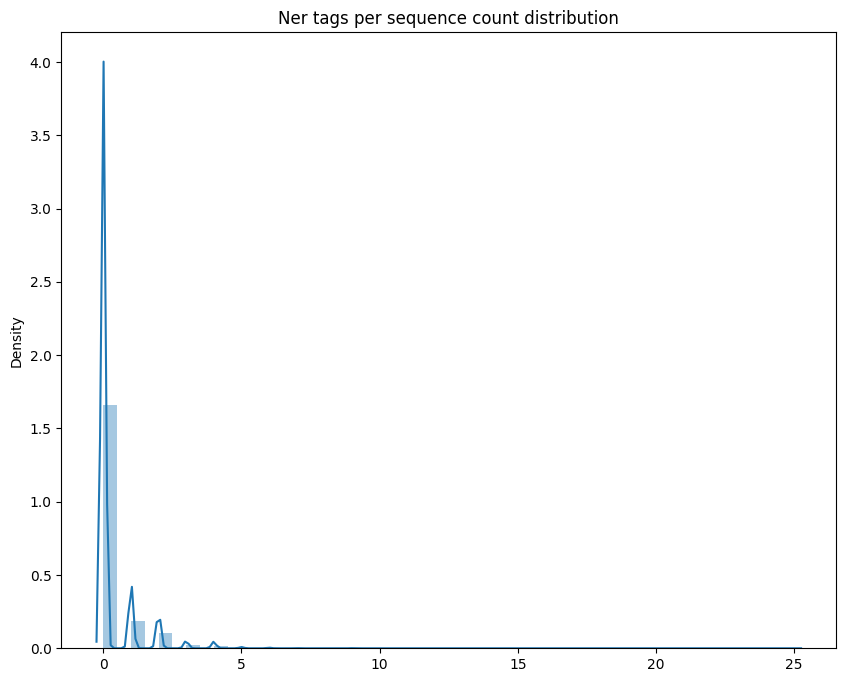

In [59]:
plt.figure(figsize=(10,8))
sns.distplot(ner_tags_per_sequence)
plt.title('Ner tags per sequence count distribution')
plt.show()

<ipython-input-60-29339b412313>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tokens_dist)


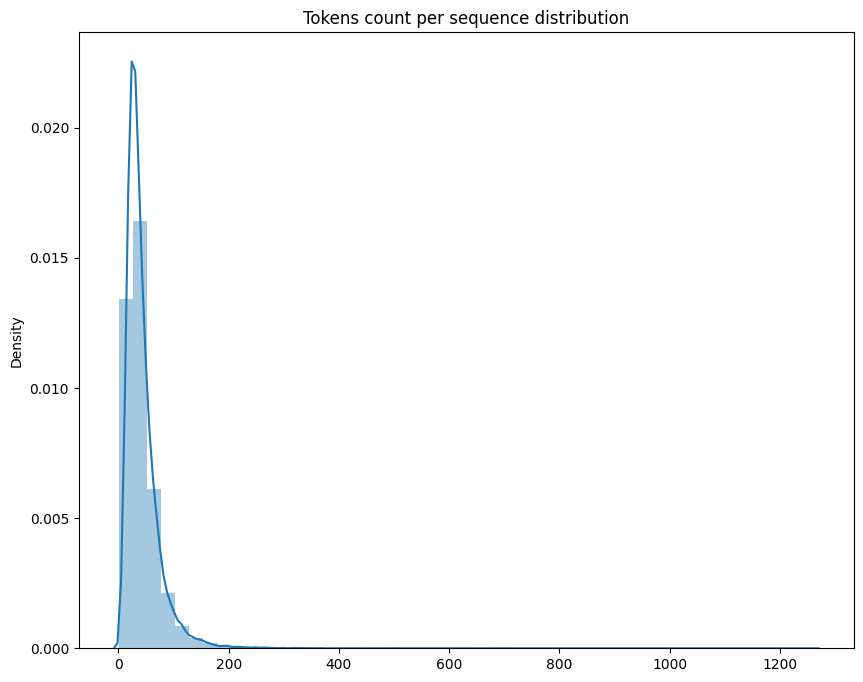

In [60]:
plt.figure(figsize=(10,8))
sns.distplot(tokens_dist)
plt.title('Tokens count per sequence distribution')
plt.show()

**Main conclusions about the data:**
1. We can take up to 200 tokens per sequence, it will cover more than 99% of rows
2. Median count of ner tags per sequence is 0, it means that dataset contains >50% of rows without any label. We should take this into account.
3. By looking at top-10 lables we see that they are not balanced, we should also take this into consideration.

<h3>3) Filtering dataset & selecting top-labels & tokenization</h3>

In [61]:
top_selected_labels, top_selected_labels_index = dbert_trainer.select_top_labels(finer_dataset, top_label_count)
model_num_labels = len(top_selected_labels_index)

In [62]:
print(f'Selected labels:')
print("\r\n".join(top_selected_labels))

Selected labels:
O
B-DebtInstrumentFaceAmount
I-DebtInstrumentFaceAmount
B-DebtInstrumentBasisSpreadOnVariableRate1
I-DebtInstrumentBasisSpreadOnVariableRate1
B-LesseeOperatingLeaseTermOfContract
I-LesseeOperatingLeaseTermOfContract
B-ContractWithCustomerLiability
I-ContractWithCustomerLiability


In [63]:
label_all_tokens=True
max_length=200
padding='max_length'
truncation=True
batch_size = 64

In [64]:
dbert_tokenizer, dbert_model = dbert_trainer.load_model_data(model_num_labels, dbert_model_name)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
token_dataset = dbert_trainer.process_data(
    finer_dataset,
    dbert_tokenizer,
    top_selected_labels_index,
    label_all_tokens,
    max_length,
    padding,
    truncation
)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [66]:
added_tokens = list(dbert_tokenizer.added_tokens_decoder.keys())
added_tokens.remove(dbert_tokenizer.unk_token_id)
added_tokens = set(added_tokens)

In [67]:
tokens_out_of_vocab = np.array(list(map(
    lambda x:  (len([w_id for w_id in x if w_id not in added_tokens]), x.count(dbert_tokenizer.unk_token_id)),
    token_dataset['input_ids']
    )))

In [68]:
percent_of_tokens_out_of_vocab = (tokens_out_of_vocab[:, 1] / tokens_out_of_vocab[:, 0]).mean()

In [69]:
print('Percent of tokens out of vocab: %.5f %%' % (100*percent_of_tokens_out_of_vocab))

Percent of tokens out of vocab: 0.00039 %


In [70]:
token_dataset_split = dbert_trainer.split_dataset(token_dataset)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/100000 [00:00<?, ? examples/s]

**Main conclusions about the data processing step**:
1. % ot tokens out of tokenizer vocab are relatively small. So we can use provided tokenizer without any doubts.
2. When selecting top-labels we should take into consideration that 1 class contains 2 labels (B-..., I-...)
3. Stratified train/test split is very important on this step


**Possible improvements:**
1. Work with digit tokens, rare tokens (SEC-BERT example)
2. Lower max_length to improve model latency
3. Try different label mapping techniques (leave only the first word label, 1 label for all subsequent subwords)
4. Work with the balance of sequences with/without any label (oversampling/downsampling)

<h3> 4) Magic part: training</h3>

In [71]:
model_trainer = dbert_trainer.train(
    dbert_model,
    dbert_model_name,
    dbert_tokenizer,
    token_dataset_split,
    top_selected_labels,
    batch_size=batch_size,
    max_seq_len=max_length,
    epochs=5
    )

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.003100,0.002532,0.663300,0.823406,0.734732,0.999192
2,0.002000,0.001777,0.808839,0.822362,0.815544,0.999493
3,0.001200,0.001802,0.767986,0.892372,0.825520,0.999491
4,0.000800,0.001718,0.847870,0.873563,0.860525,0.999616
5,0.000500,0.001894,0.811195,0.893417,0.850323,0.999571


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2663: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2663: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2663: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, u

In [183]:
model_trainer.push_to_hub(model_save_name)

CommitInfo(commit_url='https://huggingface.co/OlesB/distilbert-base-uncased-finetuned-ner_finer_139/commit/0a10c15361e760d6a80b2a2229485510e01175fb', commit_message='distilbert-base-uncased_ner_finetuned', commit_description='', oid='0a10c15361e760d6a80b2a2229485510e01175fb', pr_url=None, pr_revision=None, pr_num=None)

**Main conclusions about training**
1. During the 5 epoch loss continiue to decrease, it means we can get better results by continiue training.
2. Overall accuracy is not representative as a metric here, because we have most of the times 'O' label


**Possible next steps with fine-tuning**
1. Test more epochs
2. Test different batch size, learning rate, optimizer with [Optuna](https://optuna.org/)

<h3> 5) Eval model </h3>

In [159]:
train_predictions_scores, train_labels, _ = model_trainer.predict(token_dataset_split['train'])
train_predictions = np.argmax(train_predictions_scores, axis=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2663: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [161]:
train_eval_results, train_ci_metrics_results = dbert_trainer.eval_model(
    train_predictions,
    train_labels,
    top_selected_labels,
    verbose=False)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
val_predictions_scores, val_labels, _ = model_trainer.predict(token_dataset_split['validation'])
val_predictions = np.argmax(val_predictions_scores, axis=2)

<h4>Confusion matrix</h4>

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'ContractWithCustomerLiability': {'precision': 0.8947368421052632, 'recall': 0.6071428571428571, 'f1': 0.7234042553191489, 'number': 28}, 'DebtInstrumentBasisSpreadOnVariableRate1': {'precision': 0.8656126482213439, 'recall': 0.9690265486725663, 'f1': 0.9144050104384133, 'number': 452}, 'DebtInstrumentFaceAmount': {'precision': 0.7542857142857143, 'recall': 0.8443496801705757, 'f1': 0.7967806841046278, 'number': 469}, 'LesseeOperatingLeaseTermOfContract': {'precision': 1.0, 'recall': 0.5, 'f1': 0.6666666666666666, 'number': 8}, 'overall_precision': 0.8111954459203036, 'overall_recall': 0.8934169278996865, 'overall_f1': 0.8503232222774739, 'overall_accuracy': 0.9995711756439087}
{'recall_ci': (0.806047077922078, 0.8438852813852815, 0.8841071428571428), 'precision_ci': (0.7919469696969696, 0.8297727272727273, 0.8688825757575757)}


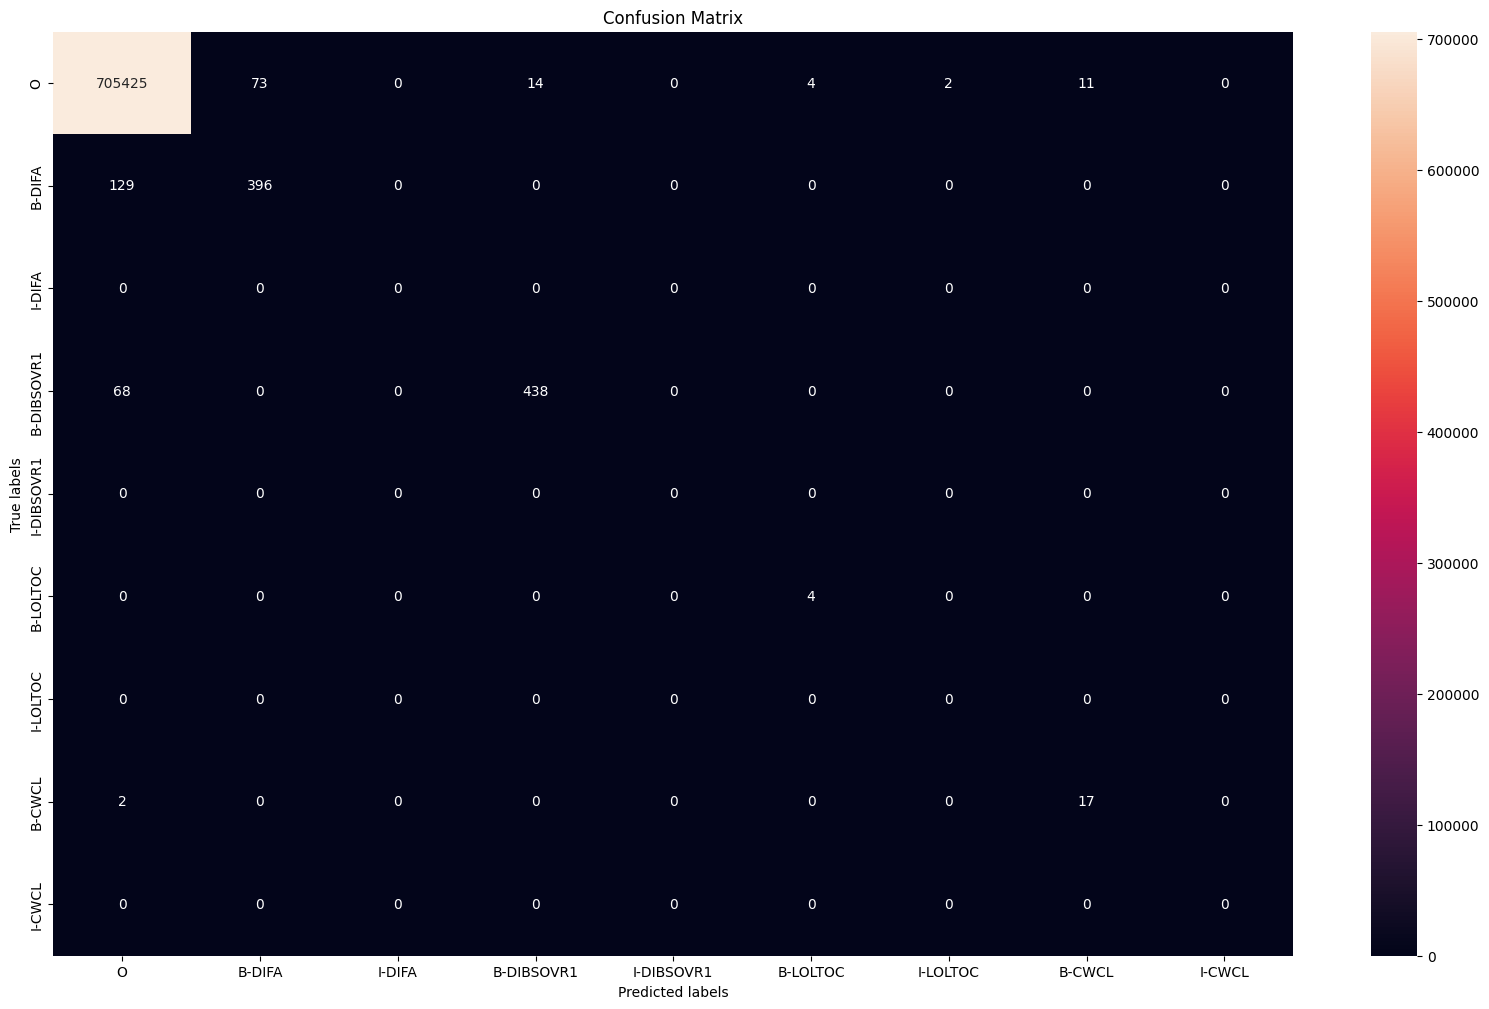

In [108]:
val_eval_results, val_ci_metrics_results = dbert_trainer.eval_model(
    val_predictions,
    val_labels,
    top_selected_labels,
    verbose=True)

In [163]:
df_train_metrics = pd.DataFrame.from_dict({k:v for k, v in train_eval_results.items() if isinstance(v, dict)}, orient='index')

df_train_metrics = df_train_metrics.style.background_gradient(cmap='Greens', subset=['precision', 'recall', 'f1'], high=1, low=0).format({
    'precision': "{:.2f}",
    'recall': "{:.2f}",
    'f1': "{:.2f}",
    'number': "{}"
})

In [129]:
df_eval_metrics = pd.DataFrame.from_dict({k:v for k, v in val_eval_results.items() if isinstance(v, dict)}, orient='index')

df_eval_metrics = df_eval_metrics.style.background_gradient(cmap='Greens', subset=['precision', 'recall', 'f1'], high=1, low=0).format({
    'precision': "{:.2f}",
    'recall': "{:.2f}",
    'f1': "{:.2f}",
    'number': "{}"
})

<h4>Train metrics</h4>

In [ ]:
display(df_train_metrics)

,precision,recall,f1,number
ContractWithCustomerLiability,0.90,0.83,0.86,96
DebtInstrumentBasisSpreadOnVariableRate1,0.95,0.98,0.96,1962
DebtInstrumentFaceAmount,0.93,0.99,0.96,2414
LesseeOperatingLeaseTermOfContract,1.00,0.52,0.68,27


<h4>Eval metrics</h4>

In [130]:
display(df_eval_metrics)

,precision,recall,f1,number
ContractWithCustomerLiability,0.89,0.61,0.72,28
DebtInstrumentBasisSpreadOnVariableRate1,0.87,0.97,0.91,452
DebtInstrumentFaceAmount,0.75,0.84,0.80,469
LesseeOperatingLeaseTermOfContract,1.00,0.50,0.67,8


In [ ]:
df_total_eval_metrics = pd.DataFrame({k:v for k, v in val_eval_results.items() if not isinstance(v, dict)}.items(), columns=['metric', 'value'])


df_total_eval_metrics = df_total_eval_metrics.style.background_gradient(cmap='Greens', subset=['value'], high=1, low=0).format({
    'value	': "{:.2f}"
})

In [165]:
df_train_total_eval_metrics = pd.DataFrame({k:v for k, v in train_eval_results.items() if not isinstance(v, dict)}.items(), columns=['metric', 'value'])


df_train_total_eval_metrics = df_train_total_eval_metrics.style.background_gradient(cmap='Greens', subset=['value'], high=1, low=0).format({
    'value	': "{:.2f}"
})

<h4>Total train metrics</h4>

In [166]:
display(df_train_total_eval_metrics)

,metric,value
0,overall_precision,0.940111
1,overall_recall,0.980440
2,overall_f1,0.959852
3,overall_accuracy,0.999885


<h4>Total eval metrics</h4>

In [149]:
display(df_total_eval_metrics)

,metric,value
0,overall_precision,0.811195
1,overall_recall,0.893417
2,overall_f1,0.850323
3,overall_accuracy,0.999571


In [177]:
significant_train_eval_diff_dict = {}
for m_name, m_ci in val_ci_metrics_results.items():
  train_m_ci = train_ci_metrics_results[m_name]
  is_singinificant_diff = (train_m_ci[1] > m_ci[1]) & (train_m_ci[2] > m_ci[2])
  significant_train_eval_diff_dict[m_name] = is_singinificant_diff

significant_train_eval_diff_df = pd.DataFrame(significant_train_eval_diff_dict.items(), columns=['metric_name', 'significant_diff'])

<h4>Train/Val metrics difference</h4>

In [178]:
display(significant_train_eval_diff_df)

,metric_name,significant_diff
0,recall_ci,True
1,precision_ci,True


**Main conclusions about evaluation**

1. Seems like a model a bit overfitted, because we see significant difference betwee train/test metrics.
2. Expectedly labels with higher frequence have better accuracy
3. There is no confusion between labels, most of confusions with 'O' label


**Possible next steps**
1. Work with overfiting (dropout, downsampling/oversampling, sampling weights)
2. Reduce model complexity (emdedding size, sequence length)

<h3> 6)Save results <h3>

In [73]:
dbert_trainer.save_data_to_local(
    model_trainer,
    token_dataset_split,
    top_selected_labels,
    model_save_dir_path,
    model_save_name,
    dataset_file_name,
    labels_file_name
  )

events.out.tfevents.1712224408.6cb2860b0e42.946.1:   0%|          | 0.00/9.75k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

events.out.tfevents.1712226124.6cb2860b0e42.946.2:   0%|          | 0.00/560 [00:00<?, ?B/s]

Saving the dataset (0/1 shards):   0%|          | 0/70000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15000 [00:00<?, ? examples/s]

<h3> 7) Convert to ONXX & compare performance </h3>

In [74]:
onnx_model = ORTModelForTokenClassification.from_pretrained(f'{model_save_dir_path}/{model_save_name}', export=True)

Framework not specified. Using pt to export the model.
Using the export variant default. Available variants are:
    - default: The default ONNX variant.
Using framework PyTorch: 2.2.1+cu121
/usr/local/lib/python3.10/dist-packages/transformers/models/distilbert/modeling_distilbert.py:246: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


In [76]:
class FinerDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        # Ensure that input_ids, attention_mask, and labels are tensors
        input_ids = torch.tensor(item['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(item['attention_mask'], dtype=torch.long)
        labels = torch.tensor(item['labels'], dtype=torch.long)  # Ensure labels are in the correct format
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }


In [77]:
finer_val_dataset = FinerDataset(token_dataset_split['validation'])
finer_val_dataloader = DataLoader(finer_val_dataset, batch_size=batch_size, shuffle=False)

In [78]:
onnx_model_preds_list = []
onnx_model_labels_list = []
for batch_data in finer_val_dataloader:
  onnx_model_preds_scores = onnx_model(**batch_data)
  onnx_model_preds = np.argmax(onnx_model_preds_scores.logits, axis=2)
  onnx_model_preds_list.append(onnx_model_preds)
  onnx_model_labels_list.append(batch_data['labels'])

In [79]:
onnx_model_preds = np.concatenate(onnx_model_preds_list)
onnx_model_true_labels = np.concatenate(onnx_model_labels_list)

In [109]:
onnx_val_eval_results, onnx_val_ci_metrics_results = dbert_trainer.eval_model(
    onnx_model_preds,
    onnx_model_true_labels,
    top_selected_labels,
    verbose=False)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
df_onnx_eval_metrics = pd.DataFrame.from_dict({k:v for k, v in onnx_val_eval_results.items() if isinstance(v, dict)}, orient='index')

df_onnx_eval_metrics = df_onnx_eval_metrics.style.background_gradient(cmap='Greens', subset=['precision', 'recall', 'f1'], high=1, low=0).format({
    'precision': "{:.2f}",
    'recall': "{:.2f}",
    'f1': "{:.2f}",
    'number': "{}"
})

<h4>ONNX eval metrics</h4>

In [158]:
display(df_onnx_eval_metrics)

,precision,recall,f1,number
ContractWithCustomerLiability,0.89,0.61,0.72,28
DebtInstrumentBasisSpreadOnVariableRate1,0.87,0.97,0.91,452
DebtInstrumentFaceAmount,0.75,0.84,0.80,469
LesseeOperatingLeaseTermOfContract,1.00,0.50,0.67,8


In [173]:
significant_diff_dict = {}
for m_name, m_ci in onnx_val_ci_metrics_results.items():
  onnx_m_ci = onnx_val_ci_metrics_results[m_name]
  is_singinificant_diff = (m_ci[1] > onnx_m_ci[1]) & (m_ci[2] > onnx_m_ci[2])
  significant_diff_dict[m_name] = is_singinificant_diff

significant_diff_df = pd.DataFrame(significant_diff_dict.items(), columns=['metric_name', 'significant_diff'])

<h4>ONNX vs Original model</h4>

In [174]:
display(significant_diff_df)

,metric_name,significant_diff
0,recall_ci,False
1,precision_ci,False


**ONNX vs Origin model performance conclusion**
1. As wee can see ONNX model eval metrics are quite the same
2. There is no significant difference in eval metrics between 2 models, so we can make a conclusion that quality of ONNX model is the same



---


<h3> Thank you for your attention  😉</h3>



